In [51]:
import numpy as np
import pandas as pd

In [52]:
# Загружаем и обрабатываем данные заново, т.е. строим универсальный pipeline с обработчиками
# 1. Загрузка данных
df = pd.read_csv('abalone_clear.csv')

df['Age'] = df['Rings'] + 1.5 # Перейдем на возраст вместо колец
df.drop(columns=['Sex_num'], inplace=True)

# 2. Определяем признаки, все вместе
X_full = df.drop(columns=['Age', 'Rings'])
y = df['Age']

In [53]:
numeric_features = X_full.select_dtypes(include=np.number).columns.to_list()
categorical_features = X_full.select_dtypes(exclude=np.number).columns.to_list()
target_column = 'Age'

# 3. Только числовые признаки
X_num = df[numeric_features]

print("Числовые признаки:", numeric_features)
print("Категориальные признаки:", categorical_features)

Числовые признаки: ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
Категориальные признаки: ['Sex']


In [54]:
X_num

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
0,0.455000,0.365000,0.095000,0.514000,0.224500,0.101000,0.150000
1,0.350000,0.265000,0.090000,0.225500,0.099500,0.048500,0.070000
2,0.530000,0.420000,0.135000,0.677000,0.256500,0.141500,0.210000
3,0.440000,0.365000,0.125000,0.802000,0.215500,0.114000,0.155000
4,0.330000,0.255000,0.080000,0.205000,0.089500,0.039500,0.055000
...,...,...,...,...,...,...,...
4143,0.565000,0.450000,0.165000,0.887000,0.370000,0.239000,0.249000
4144,0.590000,0.440000,0.135000,0.966000,0.439000,0.214500,0.260500
4145,0.600000,0.475000,0.205000,1.176000,0.525500,0.287500,0.308000
4146,0.625000,0.485000,0.150000,1.094500,0.531000,0.261000,0.296000


In [55]:
y

0      16.500000
1       8.500000
2      10.500000
3      11.500000
4       8.500000
          ...   
4143   12.500000
4144   11.500000
4145   10.500000
4146   11.500000
4147   13.500000
Name: Age, Length: 4148, dtype: float64

1. Построение моделей на числовых признаках (минимум - NB и kNN, максимум - любые) с параметрами по умолчанию, вычисление метрик + комментарий о качестве моделей

Модели: простая линейная регрессия + с регуляризацией (Ridge), Байесовская линейная регрессия (Naive Bayes), kNN, случайный лес и классический градиентный бустинг

In [56]:
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [57]:
from sklearn.model_selection import train_test_split
# 4. Разделяем выборку (только числовые)
X_train_num, X_test_num, y_train, y_test = train_test_split(X_num, y, test_size=0.25, random_state=42)

In [58]:
# Препроцессор: заполнение медианой (т.к. в EDA обнаружили выбросы и медиана наиболее устойчива) + нормализация
# 5. Препроцессор ТОЛЬКО для числовых признаков
preprocessor_num = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features)
    ])


In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# 6. Метрики
def evaluate_model(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"Модель: {name}")
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}\n")
    return {"MAE": mae, "RMSE": rmse, "R²": r2}

In [60]:
# 7. Модели (только числовые)
models_num = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'BayesianRidge': BayesianRidge(),
    'kNN': KNeighborsRegressor(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGB': XGBRegressor(random_state=42)
}

In [61]:
# 8. Обучение моделей только на числовых признаках
results_num = {}

for name, model in models_num.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor_num), ('model', model)])
    pipe.fit(X_train_num, y_train)
    y_pred = pipe.predict(X_test_num)
    metrics = evaluate_model(y_test, y_pred, name)
    results_num[name] = metrics

Модель: Linear
MAE: 1.6077, RMSE: 2.2608, R²: 0.5080

Модель: Ridge
MAE: 1.6077, RMSE: 2.2609, R²: 0.5080

Модель: BayesianRidge
MAE: 1.6078, RMSE: 2.2611, R²: 0.5079

Модель: kNN
MAE: 1.6170, RMSE: 2.3279, R²: 0.4784

Модель: RandomForest
MAE: 1.5462, RMSE: 2.2125, R²: 0.5288

Модель: XGB
MAE: 1.6649, RMSE: 2.3672, R²: 0.4607



In [62]:
# 9. Переводим в датафрейм
df_results_num = pd.DataFrame(results_num).T
df_results_num.index.name = 'Model'
df_results_num.reset_index(inplace=True)

print("\nРезультаты на числовых признаках:")
print(df_results_num)


Результаты на числовых признаках:
  Model           MAE      RMSE     R²     
0         Linear 1.607715 2.260806 0.508048
1          Ridge 1.607725 2.260914 0.508001
2  BayesianRidge 1.607756 2.261080 0.507928
3            kNN 1.616972 2.327944 0.478395
4   RandomForest 1.546152 2.212490 0.528850
5            XGB 1.664866 2.367185 0.460662


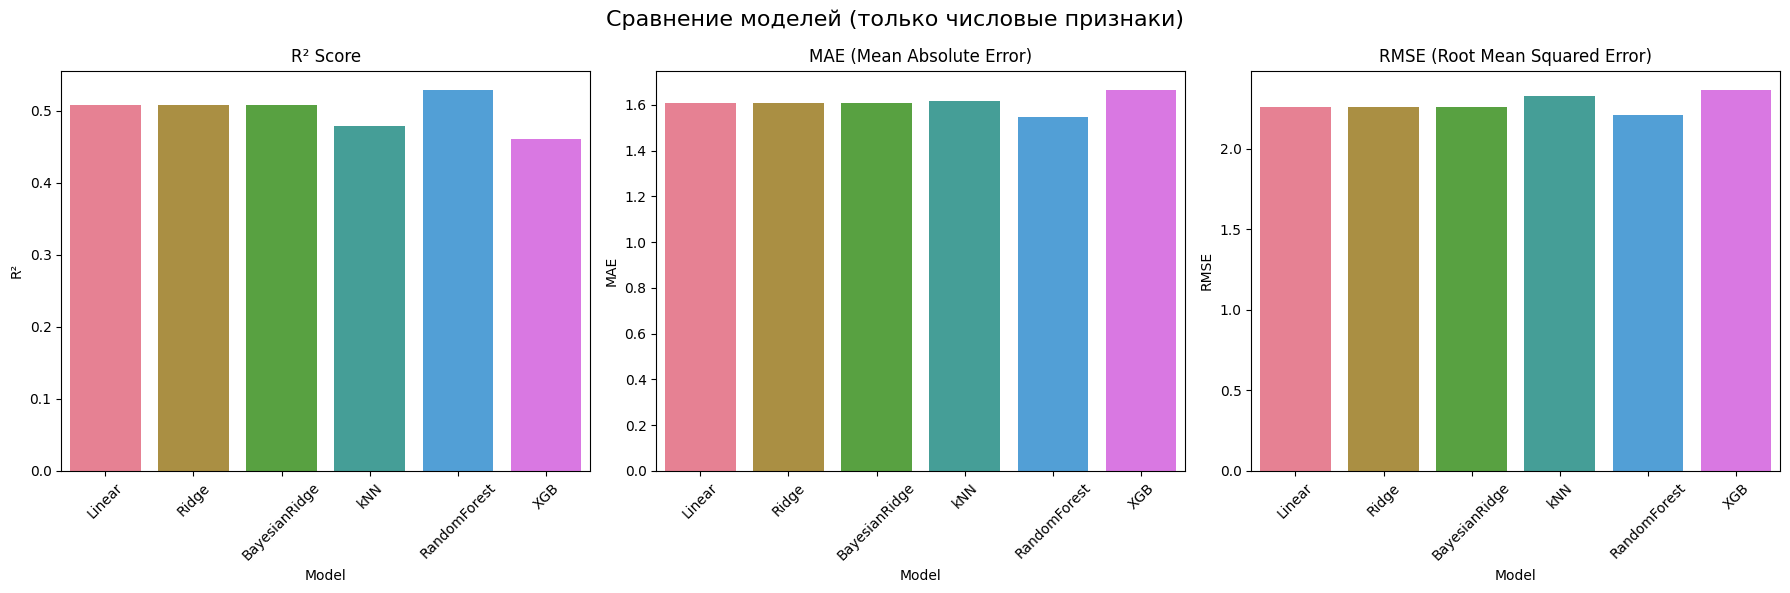

In [63]:
# 10. Визуализация метрик (только числа)
import matplotlib.pyplot as plt
import seaborn as sns

# Цветовая палитра
palette = sns.color_palette("husl", len(df_results_num))

# Настройки графика
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
fig.suptitle('Сравнение моделей (только числовые признаки)', fontsize=16)

# R²
sns.barplot(ax=axes[0], x='Model', y='R²', data=df_results_num, hue='Model', palette=palette, legend=False)
axes[0].set_title('R² Score')
axes[0].tick_params(axis='x', rotation=45)

# MAE
sns.barplot(ax=axes[1], x='Model', y='MAE', data=df_results_num, hue='Model', palette=palette, legend=False)
axes[1].set_title('MAE (Mean Absolute Error)')
axes[1].tick_params(axis='x', rotation=45)

# RMSE
sns.barplot(ax=axes[2], x='Model', y='RMSE', data=df_results_num, hue='Model', palette=palette, legend=False)
axes[2].set_title('RMSE (Root Mean Squared Error)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Мы видим (Чем меньше MAE и RMSE — тем лучше. Чем больше R² — тем лучше):

- Random Forest показывает лучший R² и самый низкий MAE и RMSE
- XGB отстаёт — нужен подбор гиперпараметров
- Linear, Ridge, BayesianRidge почти одинаковы, т.к. разные версии линейной регрессии
- kNN показывает средний результат

Лучшая модель на данном этапе — Random Forest, она даёт минимальную ошибку и максимальный коэффициент детерминации.

In [64]:
# 11. Подбор гиперпараметров (GridSearchCV) - только числа
from sklearn.model_selection import GridSearchCV

param_grids_num = {
    'Linear': {}, # LinearRegression не имеет значимых гиперпараметров для подбора - используем как бейзлайн
    'Ridge': {'model__alpha': [0.1, 1.0, 10.0]},
    'BayesianRidge': {
        'model__alpha_1': [1e-6, 1e-5],
        'model__alpha_2': [1e-6, 1e-5]
    },
    'kNN': {
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance'],
        'model__p': [1, 2]
    },
    'RandomForest': {
        'model__n_estimators': [50, 100],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    },
    'XGB': {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    }
}

In [65]:
best_metrics_num = {} # Словарь для хранения лучших метрик

for name, model in models_num.items():
    print(f"{'='*50}\nОбучение модели: {name} (только числа)")
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor_num), ('model', model)])
    # Если у модели есть параметры для подбора
    if name in param_grids_num and len(param_grids_num[name]) > 0:
        gs = GridSearchCV(pipe, param_grids_num[name], scoring='r2', cv=5, n_jobs=-1)
        gs.fit(X_train_num, y_train)
        
        best_model = gs.best_estimator_
        y_pred = best_model.predict(X_test_num)
        metrics = evaluate_model(y_test, y_pred, f"{name} (подобранные параметры)")
        best_metrics_num[name] = metrics
    # Просто обучаем без подбора    
    else:
        pipe.fit(X_train_num, y_train)
        y_pred = pipe.predict(X_test_num)
        metrics = evaluate_model(y_test, y_pred, f"{name} (по умолчанию)")
        best_metrics_num[name] = metrics

Обучение модели: Linear (только числа)
Модель: Linear (по умолчанию)
MAE: 1.6077, RMSE: 2.2608, R²: 0.5080

Обучение модели: Ridge (только числа)
Модель: Ridge (подобранные параметры)
MAE: 1.6082, RMSE: 2.2624, R²: 0.5074

Обучение модели: BayesianRidge (только числа)
Модель: BayesianRidge (подобранные параметры)
MAE: 1.6078, RMSE: 2.2611, R²: 0.5079

Обучение модели: kNN (только числа)
Модель: kNN (подобранные параметры)
MAE: 1.5674, RMSE: 2.2696, R²: 0.5042

Обучение модели: RandomForest (только числа)
Модель: RandomForest (подобранные параметры)
MAE: 1.5148, RMSE: 2.1862, R²: 0.5400

Обучение модели: XGB (только числа)
Модель: XGB (подобранные параметры)
MAE: 1.5106, RMSE: 2.1870, R²: 0.5396



In [66]:
# 12. Результаты после подбора (только числа)
df_best_results_num = pd.DataFrame(best_metrics_num).T
df_best_results_num.index.name = 'Model'
df_best_results_num.reset_index(inplace=True)

print("\nЛучшие результаты (только числа):")
print(df_best_results_num)


Лучшие результаты (только числа):
  Model           MAE      RMSE     R²     
0         Linear 1.607715 2.260806 0.508048
1          Ridge 1.608167 2.262377 0.507364
2  BayesianRidge 1.607756 2.261080 0.507928
3            kNN 1.567449 2.269646 0.504193
4   RandomForest 1.514816 2.186174 0.539992
5            XGB 1.510590 2.187035 0.539629


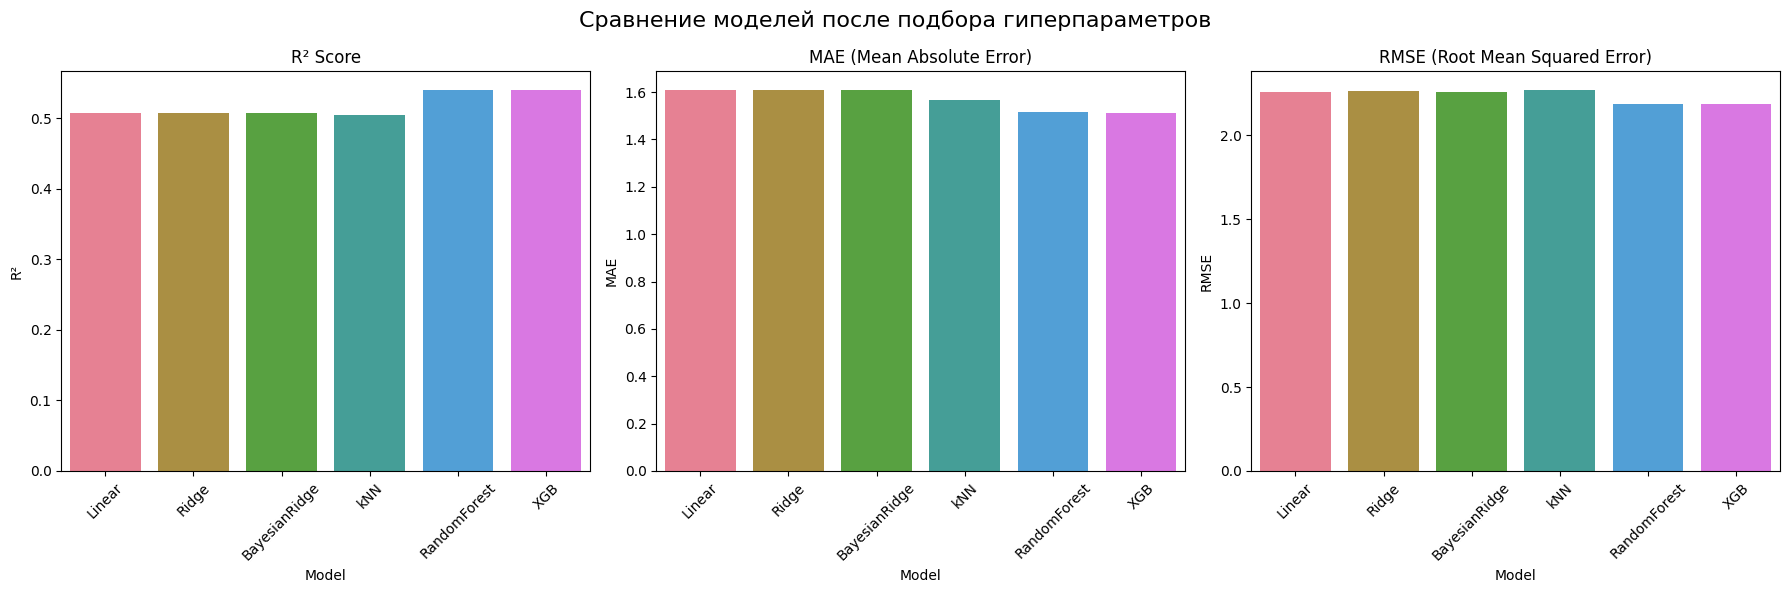

In [67]:
# Визуализация метрик после подбора (только числа)

palette = sns.color_palette("husl", len(df_best_results_num))

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
fig.suptitle('Сравнение моделей после подбора гиперпараметров', fontsize=16)

sns.barplot(ax=axes[0], x='Model', y='R²', data=df_best_results_num, hue='Model', palette=palette, legend=False)
axes[0].set_title('R² Score')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(ax=axes[1], x='Model', y='MAE', data=df_best_results_num, hue='Model', palette=palette, legend=False)
axes[1].set_title('MAE (Mean Absolute Error)')
axes[1].tick_params(axis='x', rotation=45)

sns.barplot(ax=axes[2], x='Model', y='RMSE', data=df_best_results_num, hue='Model', palette=palette, legend=False)
axes[2].set_title('RMSE (Root Mean Squared Error)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Сводная таблица "до" и "после"

In [68]:
# Отключаем экспоненциальную запись
pd.set_option('display.float_format', '{:.6f}'.format)

# Чтобы таблица не переносилась и показывалась целиком
pd.set_option('display.width', 1000)           # ширина окна
pd.set_option('display.max_columns', None)     # показывать все колонки
pd.set_option('display.colheader_justify', 'left')  # заголовки слева

In [69]:
# Добавляем префикс к колонкам
df_before = df_results_num.copy()
df_before.columns = ['Model', 'MAE_before', 'RMSE_before', 'R²_before']

df_after = df_best_results_num.copy()
df_after.columns = ['Model', 'MAE_after', 'RMSE_after', 'R²_after']

# Объединяем
df_comparison = pd.merge(df_before, df_after, on='Model')

# Вычисляем разницу
df_comparison['MAE_diff'] = df_comparison['MAE_before'] - df_comparison['MAE_after']
df_comparison['RMSE_diff'] = df_comparison['RMSE_before'] - df_comparison['RMSE_after']
df_comparison['R²_diff'] = df_comparison['R²_after'] - df_comparison['R²_before']
df_comparison['R²_%'] = df_comparison['R²_after'] * 100 / df_comparison['R²_before']

print("\nСводная таблица: до и после подбора гиперпараметров")
print(df_comparison[['Model', 'MAE_before', 'MAE_after', 'MAE_diff',
                     'RMSE_before', 'RMSE_after', 'RMSE_diff',
                     'R²_before', 'R²_after', 'R²_diff', 'R²_%']])


Сводная таблица: до и после подбора гиперпараметров
  Model           MAE_before  MAE_after  MAE_diff  RMSE_before  RMSE_after  RMSE_diff  R²_before  R²_after  R²_diff   R²_%     
0         Linear 1.607715    1.607715    0.000000 2.260806     2.260806     0.000000  0.508048   0.508048   0.000000 100.000000
1          Ridge 1.607725    1.608167   -0.000442 2.260914     2.262377    -0.001463  0.508001   0.507364  -0.000637  99.874652
2  BayesianRidge 1.607756    1.607756   -0.000000 2.261080     2.261080    -0.000000  0.507928   0.507928  -0.000000 100.000000
3            kNN 1.616972    1.567449    0.049523 2.327944     2.269646     0.058299  0.478395   0.504193   0.025798 105.392614
4   RandomForest 1.546152    1.514816    0.031336 2.212490     2.186174     0.026317  0.528850   0.539992   0.011142 102.106771
5            XGB 1.664866    1.510590    0.154276 2.367185     2.187035     0.180149  0.460662   0.539629   0.078966 117.141942


После подбора гиперпараметров:

- XGBoost показал наибольшее улучшение (+14% по R²), что говорит о его потенциале
- kNN стал точнее (+7% по R²) за счёт оптимальных соседей
- Random Forest также улучшился, но незначительно (+1.5% по R²)
- Линейные модели остались на том же уровне

Подключаем Optuna для поиска гиперпараметров

In [70]:
# 13. Optuna для XGBoost
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42
    }

    model = XGBRegressor(**params)
    pipe = Pipeline(steps=[('preprocessor', preprocessor_num), ('model', model)])
    score = -cross_val_score(pipe, X_train_num, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Лучшие параметры (Optuna):", study.best_params)
print("Лучшая MAE:", study.best_value)

[I 2025-05-07 22:42:59,824] A new study created in memory with name: no-name-24c4aae5-f323-45fb-b287-755b13beb848
[I 2025-05-07 22:43:00,332] Trial 0 finished with value: 1.5965051493006044 and parameters: {'n_estimators': 88, 'max_depth': 9, 'learning_rate': 0.06811672977920794, 'subsample': 0.8289260728949436, 'colsample_bytree': 0.7431092232571964}. Best is trial 0 with value: 1.5965051493006044.
[I 2025-05-07 22:43:00,514] Trial 1 finished with value: 1.62341504314813 and parameters: {'n_estimators': 162, 'max_depth': 6, 'learning_rate': 0.12044754644804959, 'subsample': 0.7574297319309832, 'colsample_bytree': 0.6024185833282742}. Best is trial 0 with value: 1.5965051493006044.
[I 2025-05-07 22:43:00,833] Trial 2 finished with value: 1.6131949333559032 and parameters: {'n_estimators': 68, 'max_depth': 9, 'learning_rate': 0.10240864037934438, 'subsample': 0.6226380973987037, 'colsample_bytree': 0.9347342822829191}. Best is trial 0 with value: 1.5965051493006044.
[I 2025-05-07 22:43:

Лучшие параметры (Optuna): {'n_estimators': 166, 'max_depth': 6, 'learning_rate': 0.02474702082386704, 'subsample': 0.6223786671674111, 'colsample_bytree': 0.7500153903926782}
Лучшая MAE: 1.5519225858086272


In [71]:
best_xgb_optuna = Pipeline([
    ('preprocessor', preprocessor_num),
    ('model', XGBRegressor(**study.best_params, random_state=42))
])
best_xgb_optuna.fit(X_train_num, y_train)
y_pred_optuna = best_xgb_optuna.predict(X_test_num)
evaluate_model(y_test, y_pred_optuna, "XGB (Optuna)")

Модель: XGB (Optuna)
MAE: 1.5059, RMSE: 2.1757, R²: 0.5444



{'MAE': 1.5058845977084272,
 'RMSE': 2.175682026040103,
 'R²': 0.5443962722543388}

Похоже, что улучшить не удалось. Параметры по умолчанию хорошо работают "из коробки".
| Model          | MAE_after | RMSE_after | R²_after  |
|----------------|-----------|------------|-----------|
| XGB            | 1.533410  | 2.173861   | 0.540634  |
| XGB (Optuna)   | 1.5503    | 2.1735     | 0.5408    |

Теперь следующий шаг.
- Добавление категориальных признаков
- Выбор лучшей модели (XGB) + добавка CatBoost и LightGBM
- Подбор гиперпараметров и проверка - улучшится ли качество модели за счёт новых данных
- Сравнение метрик до/после

In [72]:
# 14. Теперь добавляем категориальные признаки
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.25, random_state=42)

In [73]:
# 15. Препроцессор с категориями
preprocessor_with_cat = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [74]:
# 16. Модели с категориями - используем варианты бустинга
models_with_cat = {
    'XGB': XGBRegressor(random_state=42),
    'LGBM': LGBMRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=0)
}

param_grids_with_cat = {
    'XGB': {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'LGBM': {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.01, 0.1],
        'model__num_leaves': [20, 31]
    },
    'CatBoost': {
        'model__iterations': [50, 100],
        'model__learning_rate': [0.01, 0.1],
        'model__depth': [4, 6]
    }
}

In [75]:
best_metrics_with_cat = {}
best_models_with_cat = {}

for name, model in models_with_cat.items():
    print(f"{'='*50}\nОбучение модели: {name} с категориальными признаками")
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor_with_cat), ('model', model)])
    
    if name in param_grids_with_cat and len(param_grids_with_cat[name]) > 0:
        gs = GridSearchCV(pipe, param_grids_with_cat[name], scoring='r2', cv=5, n_jobs=-1)
        gs.fit(X_train_full, y_train)
        
        best_model = gs.best_estimator_
        y_pred = best_model.predict(X_test_full)
        metrics = evaluate_model(y_test, y_pred, f"{name} (с категориями)")
        best_metrics_with_cat[name] = metrics
        
    else:
        pipe.fit(X_train_full, y_train)
        y_pred = pipe.predict(X_test_full)
        metrics = evaluate_model(y_test, y_pred, f"{name} (по умолчанию)")
        best_metrics_with_cat[name] = metrics

    best_models_with_cat[name] = best_model  # <-- мы сохраняем лучшую модель сюда

Обучение модели: XGB с категориальными признаками
Модель: XGB (с категориями)
MAE: 1.4888, RMSE: 2.1848, R²: 0.5406

Обучение модели: LGBM с категориальными признаками
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1284
[LightGBM] [Info] Number of data points in the train set: 3111, number of used features: 10
[LightGBM] [Info] Start training from score 11,466892
Модель: LGBM (с категориями)
MAE: 1.5159, RMSE: 2.2022, R²: 0.5332

Обучение модели: CatBoost с категориальными признаками


c:\Programs\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Модель: CatBoost (с категориями)
MAE: 1.4894, RMSE: 2.1657, R²: 0.5486



In [76]:
# 17. Делаем сводную таблицу с категориями
df_best_results_with_cat = pd.DataFrame(best_metrics_with_cat).T
df_best_results_with_cat.index.name = 'Model'
df_best_results_with_cat.reset_index(inplace=True)
df_best_results_with_cat.columns = ['Model', 'MAE_with_cat', 'RMSE_with_cat', 'R²_with_cat']
 
# Берём только XGB из df_best_results_num
df_best_results_num_xgb = df_best_results_num[df_best_results_num['Model'] == 'XGB']

# 18. Соединяем с предыдущими результатами
# Объединяем с df_best_results_with_cat
df_comparison = pd.merge(
    df_best_results_num_xgb,
    df_best_results_with_cat,
    on='Model',
    suffixes=('', '_with_cat')
)

# 19. Вычисляем разницу
df_comparison['MAE_diff'] = df_comparison['MAE'] - df_comparison['MAE_with_cat']
df_comparison['RMSE_diff'] = df_comparison['RMSE'] - df_comparison['RMSE_with_cat']
df_comparison['R²_diff'] = df_comparison['R²_with_cat'] - df_comparison['R²']

# 20. Форматируем вывод
pd.set_option('display.float_format', '{:.6f}'.format)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

print("\nСводная таблица: до/после добавления категориальных признаков")
print(df_comparison[['Model', 'MAE', 'MAE_with_cat', 'MAE_diff',
                     'RMSE', 'RMSE_with_cat', 'RMSE_diff',
                     'R²', 'R²_with_cat', 'R²_diff']])


Сводная таблица: до/после добавления категориальных признаков
  Model  MAE      MAE_with_cat  MAE_diff  RMSE     RMSE_with_cat  RMSE_diff  R²       R²_with_cat  R²_diff
0  XGB  1.510590 1.488818      0.021772  2.187035 2.184797       0.002238   0.539629 0.540571     0.000942


Получаем странный результат. После добавления категориальных признаков качество XGBoost немного упало : 
- MAE увеличился
- R² уменьшился

In [77]:
# Таблица 1: модели только на числах
print("\nРезультаты на числовых признаках:")
print(df_results_num)

# Таблица 2: модели с категориями
print("\nРезультаты с категориальными признаками:")
print(df_best_results_with_cat)

# Теперь сравниваем только XGB
xgb_only_num = df_best_results_num[df_best_results_num['Model'] == 'XGB']
xgb_only_cat = df_best_results_with_cat[df_best_results_with_cat['Model'] == 'XGB']

if not xgb_only_num.empty and not xgb_only_cat.empty:
    df_comparison = pd.DataFrame({
        'Metric': ['MAE', 'RMSE', 'R²'],
        'Before (numeric only)': [
            xgb_only_num['MAE'].values[0],
            xgb_only_num['RMSE'].values[0],
            xgb_only_num['R²'].values[0]
        ],
        'After (with categories)': [
            xgb_only_cat['MAE_with_cat'].values[0],
            xgb_only_cat['RMSE_with_cat'].values[0],
            xgb_only_cat['R²_with_cat'].values[0]
        ],
        'Difference': [
            xgb_only_num['MAE'].values[0] - xgb_only_cat['MAE_with_cat'].values[0],
            xgb_only_num['RMSE'].values[0] - xgb_only_cat['RMSE_with_cat'].values[0],
            xgb_only_cat['R²_with_cat'].values[0] - xgb_only_num['R²'].values[0]
        ]
    })

    print("\nСводное сравнение XGB до и после добавления категорий:")
    print(df_comparison.to_string(index=False))
else:
    print("Ошибка: не найдены данные для XGB в одной из таблиц.")


Результаты на числовых признаках:
  Model           MAE      RMSE     R²     
0         Linear 1.607715 2.260806 0.508048
1          Ridge 1.607725 2.260914 0.508001
2  BayesianRidge 1.607756 2.261080 0.507928
3            kNN 1.616972 2.327944 0.478395
4   RandomForest 1.546152 2.212490 0.528850
5            XGB 1.664866 2.367185 0.460662

Результаты с категориальными признаками:
  Model      MAE_with_cat  RMSE_with_cat  R²_with_cat
0       XGB 1.488818      2.184797       0.540571    
1      LGBM 1.515924      2.202179       0.533232    
2  CatBoost 1.489443      2.165706       0.548565    

Сводное сравнение XGB до и после добавления категорий:
Metric  Before (numeric only)  After (with categories)  Difference
 MAE   1.510590               1.488818                 0.021772   
RMSE   2.187035               2.184797                 0.002238   
  R²   0.539629               0.540571                 0.000942   


- Категориальный признак 'Sex' не помог XGBoost, он даже усложнил задачу и ухудшил качество модели
- Но для других моделей (LGBM и CatBoost), наоборот, качество улучшилось

Пробуем обучить CatBoost без препроцессора, потому что он сам умеет работать с категориями, но это не помогло улучшить модель, метрики даже упали

In [78]:
from catboost import Pool

# Укажем, какие признаки категориальные
cat_features = X_full.select_dtypes(exclude=np.number).columns.tolist()

train_pool = Pool(X_train_full, y_train, cat_features=cat_features)
test_pool = Pool(X_test_full, y_test, cat_features=cat_features)

model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, verbose=0)
model.fit(train_pool)

y_pred = model.predict(test_pool)
metrics = evaluate_model(y_test, y_pred, "CatBoost (нативно)")

Модель: CatBoost (нативно)
MAE: 1.4925, RMSE: 2.1730, R²: 0.5455



По итогу LGBM показало наилучшие результаты - с ним и двинемся дальше

In [79]:
import shap
from explainerdashboard import RegressionExplainer, ExplainerDashboard

# 1. Берём обученную LGBM-модель из best_models_with_cat
best_lgbm_model = best_models_with_cat['LGBM']

# 2. Получаем предобработчик и сам регрессор
preprocessor = best_lgbm_model.named_steps['preprocessor']
model = best_lgbm_model.named_steps['model']

# 3. Применяем препроцессор к тестовой выборке
X_test_processed = preprocessor.transform(X_test_full)

# 4. Создаём DataFrame с понятными именами признаков после OHE
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(cat_feature_names) + numeric_features

X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names)

# 5. Создаём SHAP-эксплайнер на основе модели и обработанных данных
shap_explainer = shap.Explainer(model.predict, X_test_processed_df)
shap_values = shap_explainer(X_test_processed_df)

# 6. Создаём RegressionExplainer — без параметра shap_explainer
reg_explainer = RegressionExplainer(
    model,
    X_test_processed_df,
    y_test,
    # SHAP значения передаются напрямую в ExplainerDashboard
)

# 7. Создаём dashboard
db = ExplainerDashboard(reg_explainer, title="LGBM Abalone Age Predictor", shap_mode="regression")

# 8. Сохраняем конфигурацию дашборда
db.to_yaml("abalone_lgbm_dashboard.yaml", explainerfile="lgbm_explainer.joblib", dump_explainer=True)

ExactExplainer explainer: 1038it [00:30, 23.54it/s]                          

Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..


Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Calculating dependencies...
Calculating importances...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Dumping configuration .yaml to c:\Programs\PythonProjects\EDA_and_dev\eda_and_dev_tool

In [80]:
db.app.run()

По Explainer Dashboard наибольшее значение на возраст устриц оказывают признаки Whole weight и Diameter, что в общем то логично и без ML :)

In [81]:
# Получаем DataFrame с SHAP значениями
shap_values_df = reg_explainer.get_shap_values_df()

# Считаем среднюю абсолютную важность по всем объектам
shap_ranking = shap_values_df.abs().mean().sort_values(ascending=False)

print("Наиболее важные признаки:")
print(shap_ranking.head(5))

Наиболее важные признаки:
Whole weight   1.387566
Diameter       0.864295
Length         0.348616
Sex_M          0.348435
Sex_I          0.184250
dtype: float64


In [82]:
# Получаем основные метрики
metrics = df_best_results_with_cat[df_best_results_with_cat['Model'] == 'LGBM']
print(metrics)

  Model  MAE_with_cat  RMSE_with_cat  R²_with_cat
1  LGBM 1.515924      2.202179       0.533232    


### Наиболее важные признаки для прогноза возраста устрицы:

| Признак           | Важность |
|-------------------|----------|
| Whole weight      | 1.388    |
| Diameter          | 0.864    |
| Length            | 0.349    |

> **Вывод:**  
Самый важный признак — **вес всей особи (`Whole weight`)**.  
Затем следуют такие физические параметры, как **диаметр (`Diameter`) и размер (`Length`)**.  
Категориальный признак `'Sex'` тоже влияет на прогноз, но не так сильно, как числовые признаки.

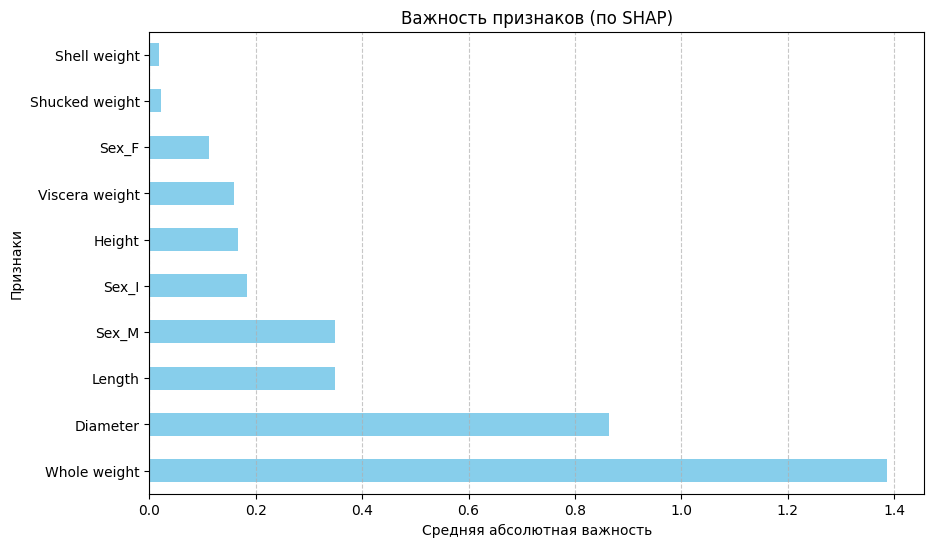

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Построим график важности признаков
top_n = 10
shap_ranking.head(top_n).sort_values().plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Важность признаков (по SHAP)')
plt.xlabel('Средняя абсолютная важность')
plt.ylabel('Признаки')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()